# Preprocessing and Tokenization

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

# Introduction

Notebook to perform Preprocessing and Tokenization on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

## Data Dictionary


| Column Name            | Description                                                               | Data Type |
| ---------------------- | ------------------------------------------------------------------------- | --------- |
| Id                     | Row ID                                                                    | int64     |
| ProductId              | Unique identifier for Product                                             | object    |
| UserId                 | Unique identifier for User                                                | object    |
| ProfileName            | Profile name of the user                                                  | object    |
| HelpfulnessNumerator   | Number of users who found the review helpful                              | int64     |
| HelpfulnessDenominator | Number of users who indicated wether they found the review helpful or not | int64     |
| Score                  | Rating between 1 and 5                                                    | int64     |
| Time                   | Timestamp for the review                                                  | int64     |
| Summary                | Brief summary of the review                                               | object    |
| Text                   | Full review                                                               | object    |


Previously, we performed EDA and noticed there were no missing values, and that there was a class imbalance in the `Score`. From the table above, we'll only use `Text` and `Score` as features and target variable, respectively.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import preprocess_dataset

In [4]:
preprocess_dataset?

Signature: preprocess_dataset(csv_filename, rebalance=True)
Docstring:
Function to preprocess a reviews datascet in csv into a dataframe with score and text. It performs the following steps:
    1. Drop duplicate rows
    2. Map score from 1-5 to 0-2
    3. Rebalance the dataframe based on the scores

Parameters
----------
csv_filename : str
    Path to the csv file containing the data. Note the file is expected to be compressed using gzip.

rebalance : bool, optional
    Optional flag indicates to balance the number of reviews.

Returns
-------
tuple
    Pandas DataFrames (df_orig, df_rebalanced), each with two columns: text and review score.

    if rebalance is False
        df_orig : contains all records
        df_rebalanced : is an empty dataframe

    if rebalance is True
        df_orig : contains all records minus those used to rebalance the review score
        df_rebalanced : contains all records used to balanced number of reviews by score

    Note that in either case pd.co

# Import Libraries and Load DataFrame

In [5]:
import numpy as np
import pandas as pd

In [6]:
file_path = '../data/Reviews.csv.gz'

In [7]:
dforig, dfnew = preprocess_dataset(file_path,rebalance=True)

In [8]:
dforig.shape

(304317, 2)

In [9]:
dfnew.shape

(89262, 2)

In [10]:
dfnew.shape[0] + dforig.shape[0]

393579

In [11]:
dfnew['Score'].value_counts()

Score
0    29754
1    29754
2    29754
Name: count, dtype: int64

In [12]:
dforig['Score'].value_counts()

Score
2    277004
0     27313
Name: count, dtype: int64

# Text Cleaning

In this section we'll add some text cleaning routines, to make the tokenization process faster. We'll remove html tags, extra whitespace, and punctuation.

# Tokenization

In this section we'll tokenize the contents of `dfnew`. The intent will be to use the Bag-of-Words model with Scikit-Learn.

We need to:

1. Use spaCy to define a custom tokenizer that removes punctuation, stop words, and performs lemmatization
2. Instantiate a `CountVectorizer` and pass custom tokenizer
3. Figure out what is the minimum document frequency for the tokens

## Testing the custom tokenizer

In [13]:
# get the first 5 reviews of the dataset
dftest = dfnew['Text'].head()
first5_rev = dftest.values.tolist()

In [14]:
import spacy

def custom_tokenizer(sentence):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(sentence)

    token_list = [token.lemma_ 
                  for token in doc 
                  if not token.is_punct 
                  and not token.is_stop 
                  and not token.is_space 
                  and not token.is_digit 
                  and not token.is_currency
                 ]

    return token_list

In [15]:
# tokenizer
custom_tokenizer(first5_rev[0])

['husband',
 'originally',
 'Germany',
 'enjoy',
 'good',
 'hearty',
 'bread',
 'hard',
 'crust',
 'order',
 'mix',
 'Amazon.com',
 'mind',
 'unfortunately',
 'disappoint',
 'bread',
 'rise',
 'expect',
 'thick',
 'crust',
 'crusty',
 'like',
 'bread',
 'Germany',
 'actually',
 'tough".<br',
 '/>i',
 'bread',
 'maker',
 'prepare',
 'follow',
 'direction',
 'T.',
 'yeast',
 'inferior',
 'check',
 'date',
 'mix',
 'expired.<br',
 '/>So',
 'purchase',
 'fact',
 'second',
 'package',
 'sit',
 'shelf']

In [16]:
# show the full review
print(first5_rev[0])

My husband is originally from Germany and enjoys good hearty breads with hard crusts.  I order this mix from Amazon.com with him in mind.  Unfortunately we were disappointed because the bread did not rise as expected.  It did get a thick crust, but was not crusty like the breads in Germany. It was actually "tough".<br />I used the bread maker to prepare it and followed the directions to a T.  Perhaps the yeast was inferior.  Checked the date on the mix and it was not expired.<br />So I will not be purchasing it again.  In fact, I have the second two packages sitting on the shelf.


In [17]:
custom_tokenizer(first5_rev[3])

['give',
 'product',
 'star',
 'know',
 'product',
 'old',
 'case',
 'bad',
 'tea',
 'open',
 'box',
 'home',
 'office',
 'return',
 'product',
 'tea',
 'taste',
 'bad',
 'smell',
 'bad',
 'try',
 'throw',
 'tea']

In [18]:
print(first5_rev[3])

If I could have given this product no stars I would have.  I don't know if the product was old or just a case of bad tea.  I opened both boxes (one for home and one for the office) or I would have returned the product.  The tea not only tasted bad but it smelled bad as well. I even had others try it and they had to throw the tea out as well.


## Test the Count Vectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer)
bagofwords.fit(first5_rev)

first5_rev_transformed = bagofwords.transform(first5_rev)
first5_rev_transformed.shape

/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5, 130)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def top_words(Xtransf,bagofwords,num_words=20):
    assert isinstance(num_words,int),"num_words must be an integer"
    
    word_counts = pd.DataFrame(
        {"counts": Xtransf.toarray().sum(axis=0)},
        index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=False)

    word_counts.head(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {num_words} most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

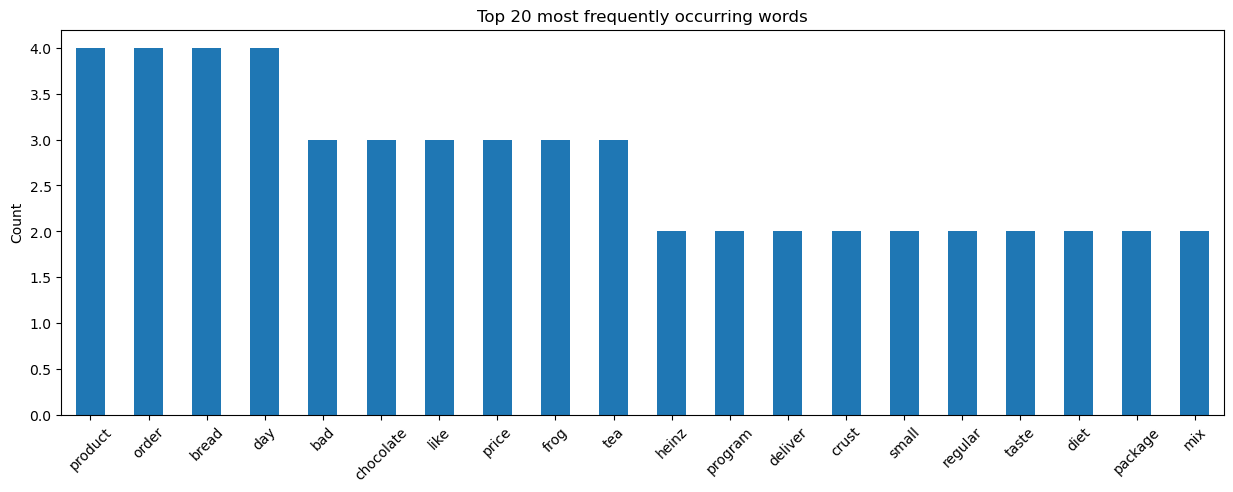

In [22]:
top_words(first5_rev_transformed,bagofwords,20)

# Checking for the minimum document frequency

Now we'll add a large portion of the reviews into the tokenization pipeline

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
def small_sample(dfnew,fraction):
    # fraction = 0.1
    
    acc = pd.DataFrame()
    
    avail_score = dfnew['Score'].value_counts().index
    
    for score in avail_score:
        tempdf = dfnew.query(f'Score == {score}').sample(frac = fraction, random_state = 10).copy()
    
        acc = pd.concat([acc,tempdf], axis = 0)
    
    return acc

In [25]:
df_downsampled = small_sample(dfnew,0.1)

In [26]:
df_downsampled.shape

(8925, 2)

In [27]:
df_downsampled['Score'].value_counts()

Score
0    2975
1    2975
2    2975
Name: count, dtype: int64

In [28]:
# # extract the values from `dfnew` dataframe
# X = dfnew['Text']
# y = dfnew['Score'].values

In [29]:
# extract the values from `df_downsampled` dataframe
X = df_downsampled['Text']
y = df_downsampled['Score'].values

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 10,stratify = y)

In [31]:
X_train.shape[0] + X_test.shape[0]

8925

In [32]:
X.shape

(8925,)

In [33]:
X_train.shape

(7140,)

In [34]:
import spacy
nlp = spacy.load("en_core_web_sm")

def custom_tokenizer2(sentence):
    
    doc = nlp(sentence)

    token_list = [token.lemma_ 
                  for token in doc 
                  if not token.is_punct 
                  and not token.is_stop 
                  and not token.is_space 
                  and not token.is_digit 
                  and not token.is_currency
                 ]

    return token_list

In [35]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer2,
                             min_df = 0.1
                            )


In [36]:
bagofwords.fit(X_train.sample(frac = 0.3))

/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(min_df=0.1,
                tokenizer=<function custom_tokenizer2 at 0x16cb0c180>)

In [37]:
X_train_transformed = bagofwords.transform(X_train.sample(frac = 0.3))
X_train_transformed.shape

(2142, 27)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def bottom_words(Xtransf,bagofwords,num_words=20):
    assert isinstance(num_words,int),"num_words must be an integer"
    
    word_counts = pd.DataFrame(
        {"counts": Xtransf.toarray().sum(axis=0)},
        index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=True)

    word_counts.head(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {num_words} least frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

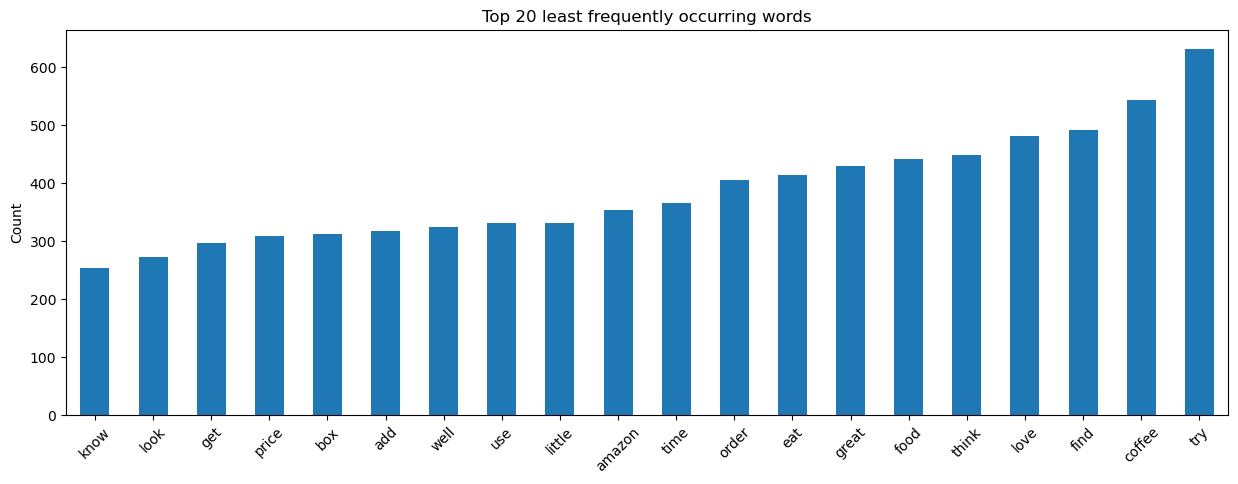

In [39]:
bottom_words(X_train_transformed,bagofwords)

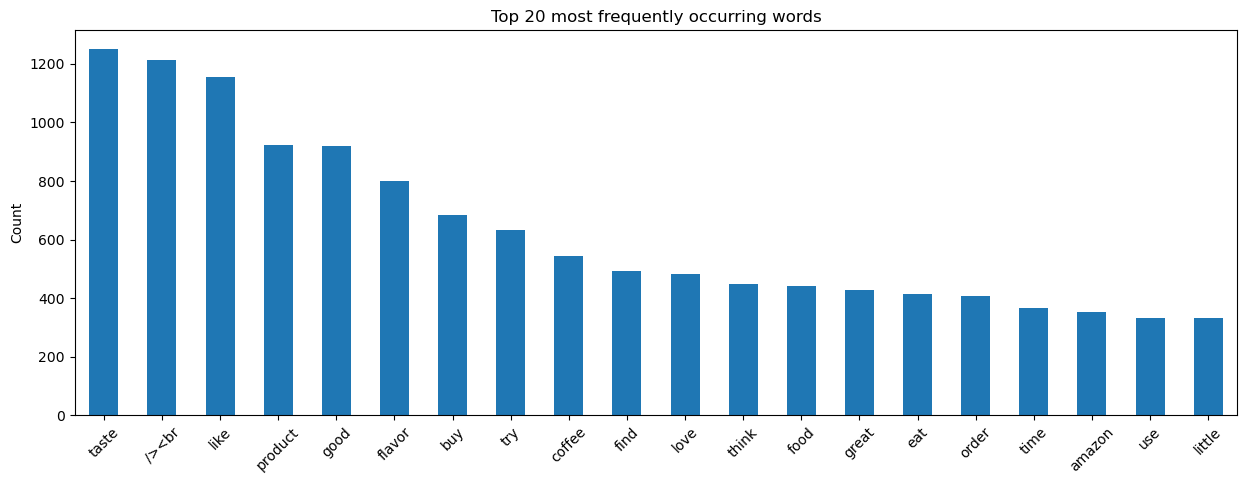

In [40]:
top_words(X_train_transformed,bagofwords)

# Comments and further actions

- We see from the top words that there might be html tags present in the text. We will have to deal with those in the preprocessing prior to tokenization using a text cleaning function.
- We've added a preprocessing step to remove duplicate text reviews.
- We'll need to abstract the top and bottom words plotting function, perhaps in a single function call with two plots